In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU count: 1
Current device: 0
Device name: Quadro RTX 8000


/BiO/home/jk/anaconda3/envs/jk_esm/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


In [4]:
print(torch.cuda.device_count())


1


In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, auto as tqdm_auto
import pandas as pd

# Hugging Face & PEFT

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, PeftModel

# Scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    brier_score_loss,
    auc
)
from sklearn.manifold import TSNE
from sklearn.calibration import calibration_curve


# Dimensionality Reduction & Visualization

import umap.umap_ as umap
import seaborn as sns


In [7]:
# Full data
data = pd.read_csv('/BiO/home/jk/Research_MHC/MHC_II/compact_convolutional/MHC_II_human_mouse_MHC_full_cleaned_shuffled_data_12_04_2025.csv')

In [ ]:
data = pd.read_csv("Training_MHCII.csv") ## Main data file

In [8]:
data.head()

,MHC_allele,Peptide,Immunogenicity,Sequence
0,HLA-DRB1-0101,YLMDKLNLTKSDVQL,0,MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHF...
1,H2-IAb,SDFMSKVNGAVKRVA,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...
2,H2-IAb,IIDWKGANPVTVINE,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...
3,H2-IAb,MIALLILSLTCSXXX,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...
4,H2-IAb,GYESLDLCLEGVGIH,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...


In [10]:
data = data.rename(columns={
    "Immunogenicity": "labels"
})

In [11]:
data.columns

Index(['MHC_allele', 'Peptide', 'labels', 'Sequence'], dtype='object')

In [12]:
# Create merged input text for ESM
#def merge_inputs(row):
#    return f"[PEP] {row['Peptide']} [MHC] {row['Sequence']}"
def merge_inputs(row):
    return row["Peptide"] + row["Sequence"]
data["text"] = data.apply(merge_inputs, axis=1)

# Convert labels to int
data["labels"] = data["labels"].astype(int)

data.head()


,MHC_allele,Peptide,labels,Sequence,text
0,HLA-DRB1-0101,YLMDKLNLTKSDVQL,0,MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHF...,YLMDKLNLTKSDVQLMVCLKLPGGSCMTALTVTLMVLSSPLALAGD...
1,H2-IAb,SDFMSKVNGAVKRVA,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...,SDFMSKVNGAVKRVAMALQIPSLLLSAAVVVLMVLSSPGTEGGDSE...
2,H2-IAb,IIDWKGANPVTVINE,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...,IIDWKGANPVTVINEMALQIPSLLLSAAVVVLMVLSSPGTEGGDSE...
3,H2-IAb,MIALLILSLTCSXXX,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...,MIALLILSLTCSXXXMALQIPSLLLSAAVVVLMVLSSPGTEGGDSE...
4,H2-IAb,GYESLDLCLEGVGIH,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...,GYESLDLCLEGVGIHMALQIPSLLLSAAVVVLMVLSSPGTEGGDSE...


In [13]:
train_df, val_df = train_test_split(
    data,
    test_size=0.2,
    stratify=data["labels"],
    random_state=42
)
train_ds = Dataset.from_pandas(train_df,preserve_index= False)
val_ds   = Dataset.from_pandas(val_df, preserve_index = False)

#### Tokenizer

In [14]:
from transformers import AutoTokenizer

model_name = "facebook/esm2_t33_650M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=1024
)

tokenizer.add_special_tokens(
    {"additional_special_tokens": ["[PEP]", "[MHC]"]}
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)

train_tok = train_tok.remove_columns(
    ["text", "MHC_allele", "Peptide", "Sequence"]
)
val_tok = val_tok.remove_columns(
    ["text", "MHC_allele", "Peptide", "Sequence"]
)

train_tok.set_format("torch")
val_tok.set_format("torch")



Map:   0%|          | 0/6309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

#### Model + LoRA

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.2,
    target_modules=["query", "key", "value"]
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 3,669,762 || all params: 656,026,265 || trainable%: 0.5593925420043967


In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    pos_probs = probs[:, 1]

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "auc_roc": roc_auc_score(labels, pos_probs),
        "auc_pr": average_precision_score(labels, pos_probs)
    }


In [18]:
args = TrainingArguments(
    output_dir="./esm2_mhcII_lora",
    seed=42,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="auc_roc",
    remove_unused_columns=False,   #  
    dataloader_num_workers=0,
    report_to="none",
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)


In [19]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    #label_names=["labels"],
    callbacks=[early_stopping]
)

trainer.train()


/BiO/home/jk/anaconda3/envs/jk_esm/lib/python3.11/site-packages/accelerate/accelerator.py:469: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Auc Roc,Auc Pr
1,No log,0.418795,0.813054,0.727273,0.800000,0.883667,0.802751


TrainOutput(global_step=394, training_loss=0.48021159680361675, metrics={'train_runtime': 1075.0358, 'train_samples_per_second': 11.737, 'train_steps_per_second': 0.366, 'total_flos': 2.530225963881984e+16, 'train_loss': 0.48021159680361675, 'epoch': 1.9936628643852978})

In [20]:
trainer.save_model("esm2_finetuned_peptide_mhc")
tokenizer.save_pretrained("esm2_finetuned_peptide_mhc")

('esm2_finetuned_peptide_mhc/tokenizer_config.json',
 'esm2_finetuned_peptide_mhc/special_tokens_map.json',
 'esm2_finetuned_peptide_mhc/vocab.txt',
 'esm2_finetuned_peptide_mhc/added_tokens.json')

In [15]:
trainer.save_model("esm2_mhcII_lora_finetuned_12_04_2025")
tokenizer.save_pretrained("esm2_mhcII_lora_finetuned12_04_2025")

('esm2_mhcII_lora_finetuned12_04_2025/tokenizer_config.json',
 'esm2_mhcII_lora_finetuned12_04_2025/special_tokens_map.json',
 'esm2_mhcII_lora_finetuned12_04_2025/vocab.txt',
 'esm2_mhcII_lora_finetuned12_04_2025/added_tokens.json')

In [5]:
import seaborn as sns
sns.set_style("whitegrid")



In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
base_model = "facebook/esm2_t33_650M_UR50D"
lora_model_path = "esm2_mhcII_lora_finetuned_12_04_2025" ##  fine-tunned model or esm2_finetuned_peptide_mhc

tokenizer = AutoTokenizer.from_pretrained(lora_model_path, trust_remote_code=True)

model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    num_labels=2,
    torch_dtype=torch.float16
)

model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()
model.cuda()
print("Model loaded successfully!")


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


In [18]:
from sklearn.model_selection import train_test_split

data["text"] = data["text"].astype(str)

train_df, val_df = train_test_split(
    data, test_size=0.2, stratify=data["labels"], random_state=42
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding=True,
        truncation=True,
        max_length=512
    )

train_tok = train_df.apply(tokenize, axis=1)
val_tok = val_df.apply(tokenize, axis=1)


In [19]:
#### task 1

100%|██████████████████████████████████████████████████████████████████████| 1320/1320 [00:53<00:00, 24.49it/s]


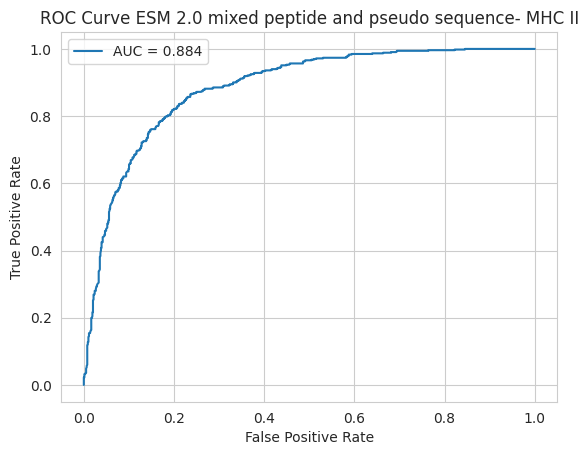

In [21]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_probs(dataset):
    probs = []
    true = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
        enc = tokenizer(row["text"], return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")
        with torch.no_grad():
            logits = model(**enc).logits
            p = torch.softmax(logits, dim=-1)[0,1].item()
        probs.append(p)
        true.append(row["labels"])
    return np.array(true), np.array(probs)

y_true, y_prob = get_probs(val_df)

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve ESM 2.0 mixed peptide and MHC sequence- MHC II")
plt.show()


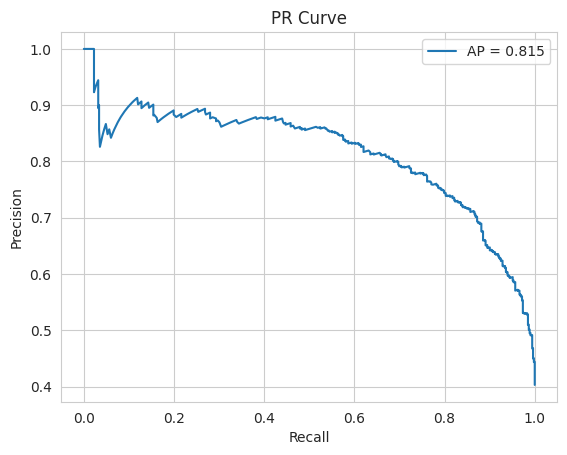

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("PR Curve")
plt.show()


100%|██████████████████████████████████████████████████████████████████████| 1320/1320 [00:53<00:00, 24.48it/s]
/BiO/home/jk/anaconda3/envs/jk_esm/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


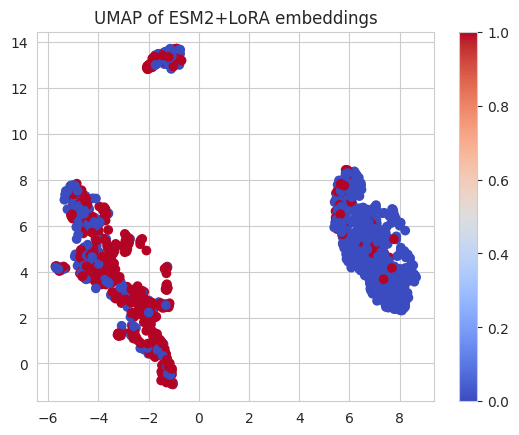

In [24]:
from sklearn.manifold import TSNE
import umap
import numpy as np

def extract_embeddings(df):
    embeds, labels = [], []

    model.eval()

    for _, row in tqdm(df.iterrows(), total=len(df)):
        enc = tokenizer(
            row["text"],
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to("cuda")

        with torch.no_grad():
            # IMPORTANT: use model.esm not model.base_model
            outputs = model.esm(**enc)
            hidden = outputs.last_hidden_state  # (1, L, 1280)
            pooled = hidden.mean(dim=1).squeeze().cpu().numpy()

        embeds.append(pooled)
        labels.append(row["labels"])

    return np.array(embeds), np.array(labels)

embeds, labels = extract_embeddings(val_df)

reducer = umap.UMAP(n_neighbors=20)
umap_emb = reducer.fit_transform(embeds)

plt.scatter(umap_emb[:,0], umap_emb[:,1], c=labels, cmap="coolwarm")
plt.title("UMAP of ESM2+LoRA embeddings")
plt.colorbar()
plt.show()


100%|██████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.22it/s]


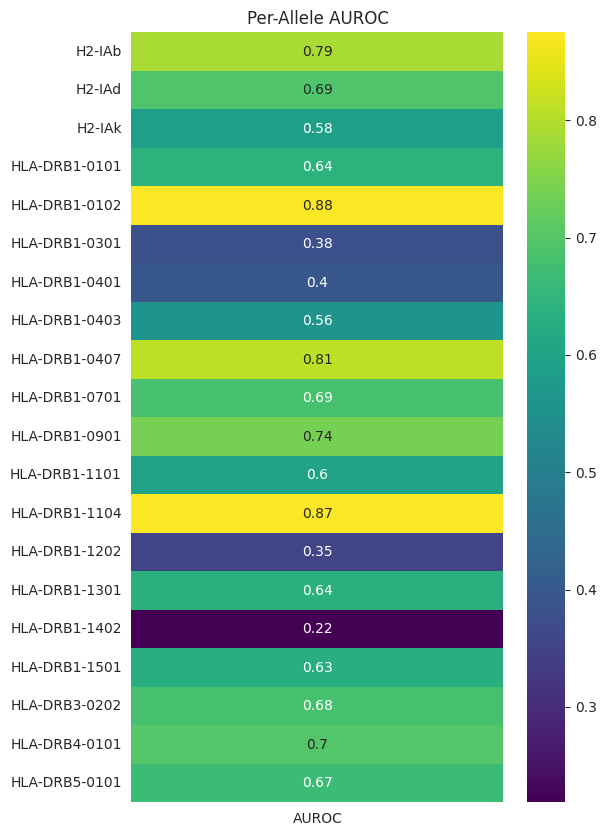

In [25]:
import seaborn as sns

alleles = sorted(data["MHC_allele"].unique())
results = {}

for allele in alleles:
    sub = val_df[val_df["MHC_allele"] == allele]
    if len(sub) < 10:
        continue
    y_t, y_p = get_probs(sub)
    results[allele] = auc(*roc_curve(y_t, y_p)[:2])

heat_df = pd.DataFrame.from_dict(results, orient="index", columns=["AUROC"])

plt.figure(figsize=(6,10))
sns.heatmap(heat_df, annot=True, cmap="viridis")
plt.title("Per-Allele AUROC")
plt.show()


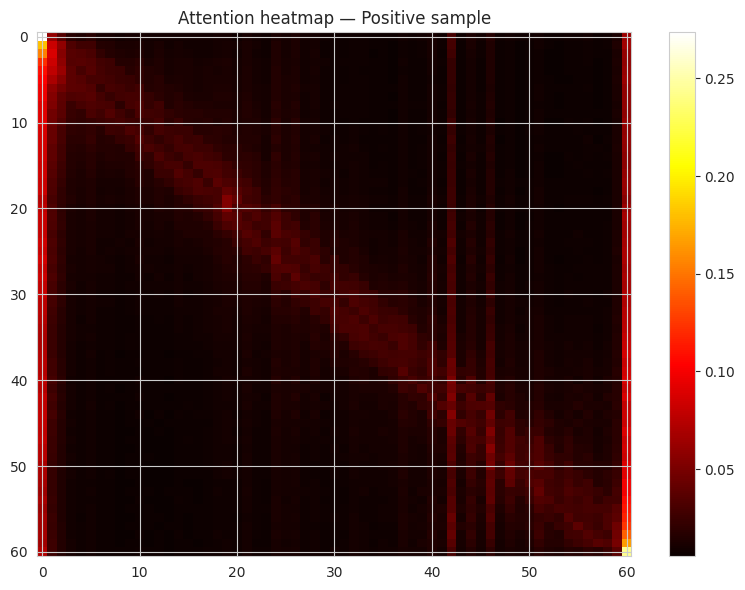

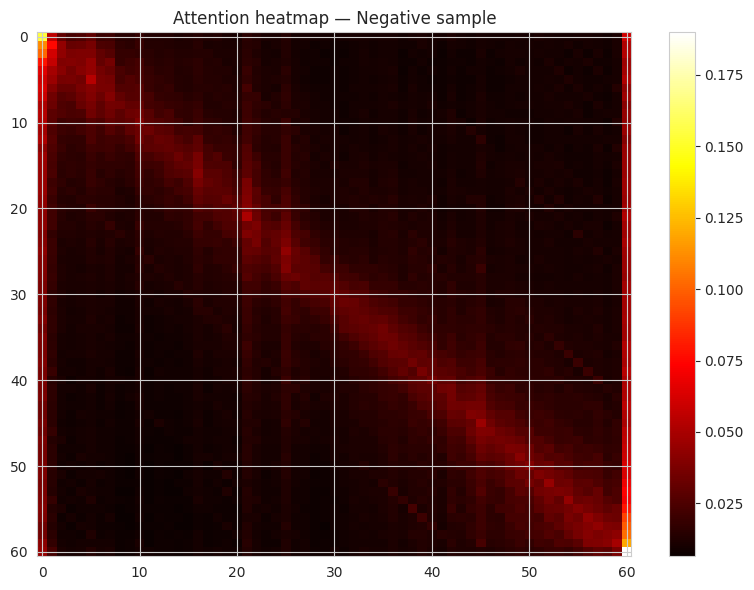

In [27]:
def get_attention_map(text):
    # Tokenize
    enc = tokenizer(text, return_tensors="pt", truncation=True).to("cuda")

    # Get attention from base model
    with torch.no_grad():
        outputs = model.base_model(**enc, output_attentions=True)
        attn = outputs.attentions   # list: L layers, each (1, H, S, S)

    # Convert list → tensor: (L, 1, H, S, S)
    attn = torch.stack(attn)  

    # Remove batch dimension (always 1 → index 0)
    attn = attn[:, 0]               # (L, H, S, S)

    # Average across layers and heads
    attn_map = attn.mean(dim=0).mean(dim=0)   # (S, S)

    return attn_map.cpu().numpy(), enc


# ---- Extract one positive + one negative example ----
sample_pos = val_df[val_df.labels==1]["text"].iloc[0]
sample_neg = val_df[val_df.labels==0]["text"].iloc[0]

attn_pos, enc_pos = get_attention_map(sample_pos)
attn_neg, enc_neg = get_attention_map(sample_neg)


# ---- Plot positive sample ----
plt.figure(figsize=(8,6))
plt.imshow(attn_pos, cmap="hot", aspect="auto")
plt.title("Attention heatmap — Positive sample")
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- Plot negative sample ----
plt.figure(figsize=(8,6))
plt.imshow(attn_neg, cmap="hot", aspect="auto")
plt.title("Attention heatmap — Negative sample")
plt.colorbar()
plt.tight_layout()
plt.show()


In [31]:
def get_attention_matrix(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True).to("cuda")

    with torch.no_grad():
        out = model.base_model(**enc, output_attentions=True)
        attn = out.attentions

    attn = torch.stack(attn)           # (L, 1, H, S, S)
    attn = attn[:, 0]                  # remove batch
    attn = attn.mean(0).mean(0)        # average → (S, S)

    return attn.cpu().numpy(), enc


# ------- FIXED REGION SPLIT: peptide + MHC --------------
def get_pep_mhc_indices(enc, text):
    # split raw text (your format: "PEP MHC")
    try:
        pep, mhc = text.split(" ", 1)
    except:
        raise ValueError("❌ Input text must have format: '<peptide> <mhc>'")

    pep_toks = tokenizer.tokenize(pep)
    mhc_toks = tokenizer.tokenize(mhc)

    # token indices inside full sequence
    pep_start = 1                     # token 0 is [CLS]
    pep_end   = pep_start + len(pep_toks) - 1

    mhc_start = pep_end + 1
    mhc_end   = mhc_start + len(mhc_toks) - 1

    return pep_start, pep_end, mhc_start, mhc_end


def plot_block_attention(attn, i1, i2, j1, j2, title):
    block = attn[i1:i2+1, j1:j2+1]

    plt.figure(figsize=(7, 5))
    plt.imshow(block, cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Position")
    plt.tight_layout()
    plt.show()

    return block



=== Positive sample ===
Peptide token range: 1 5
MHC token range: 6 59


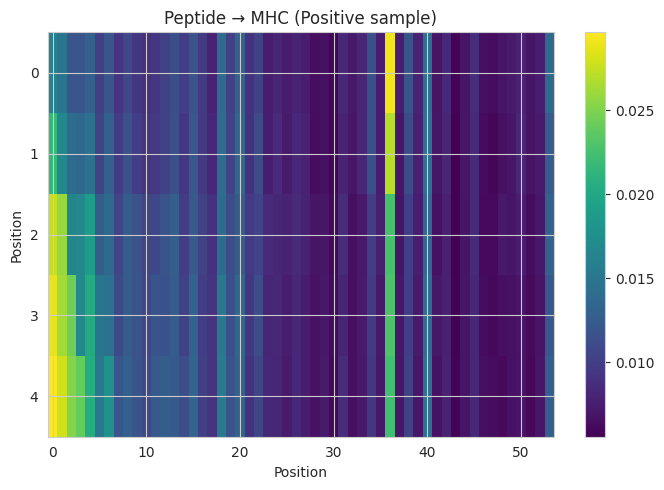

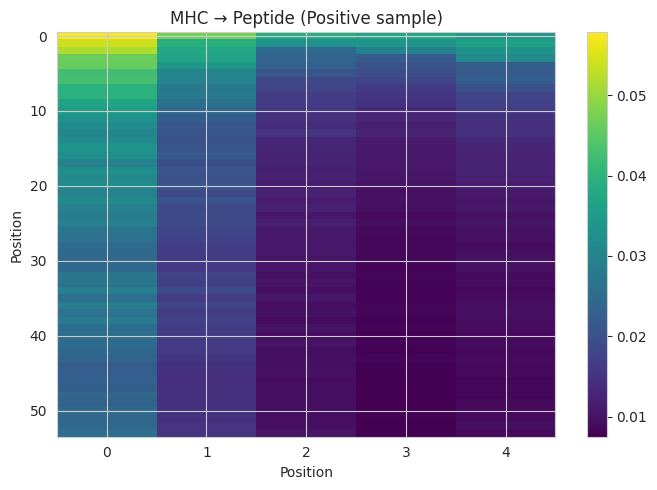


=== Negative sample ===
Peptide token range: 1 5
MHC token range: 6 59


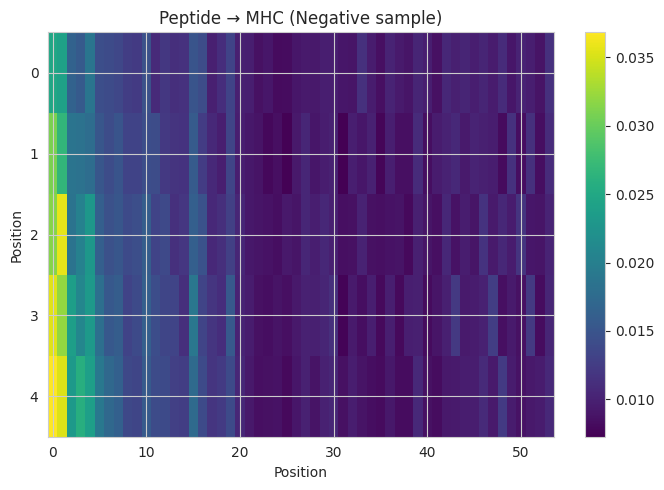

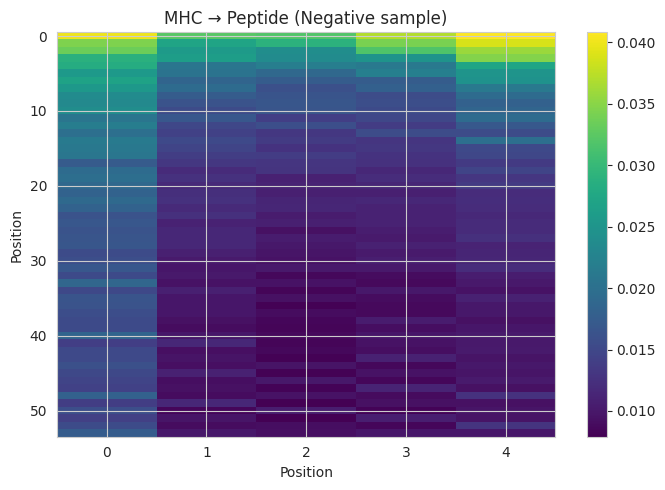

In [32]:
def run_attention_block_visualization(text, label=""):
    print(f"\n=== {label} ===")
    attn, enc = get_attention_matrix(text)

    pep_start, pep_end, mhc_start, mhc_end = get_pep_mhc_indices(enc, text)

    print("Peptide token range:", pep_start, pep_end)
    print("MHC token range:", mhc_start, mhc_end)

    # Peptide → MHC
    plot_block_attention(attn, pep_start, pep_end, mhc_start, mhc_end,
                         f"Peptide → MHC ({label})")

    # MHC → Peptide
    plot_block_attention(attn, mhc_start, mhc_end, pep_start, pep_end,
                         f"MHC → Peptide ({label})")


run_attention_block_visualization(sample_pos, "Positive sample")
run_attention_block_visualization(sample_neg, "Negative sample")


In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure model outputs attentions
model.config.output_attentions = True


def get_pep_mhc_indices(enc):
    """
    Extract peptide and MHC token spans inside ESM2 tokenized input.
    Your format: `[PEP] <pep> [MHC] <mhc_pseudo>`
    
    ESM breaks [PEP] into tokens like '[', 'PE', 'P', ']' etc.
    So we detect the peptide sequence by matching the actual amino acids.
    """
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    # Extract raw amino-acids from text
    full_text = tokenizer.decode(enc["input_ids"][0], skip_special_tokens=True)

    # Find peptide and MHC seq (from your df)
    # From enc we cannot recover easily, so we detect markers directly
    text = " ".join(tokens)

    # Identify where the actual AA sequences occur
    # (Find first continuous AA-block = peptide)
    aa_set = set(list("ACDEFGHIKLMNPQRSTVWY"))

    aa_blocks = []
    current_block = []
    start = None

    for i, tok in enumerate(tokens):
        clean = tok.replace("▁", "")  # ESM uses "▁" as underscore char
        if all(c in aa_set for c in clean):
            if start is None:
                start = i
            current_block.append(i)
        else:
            if current_block:
                aa_blocks.append(current_block)
                current_block = []
                start = None

    if current_block:
        aa_blocks.append(current_block)

    if len(aa_blocks) < 2:
        raise ValueError("Could not detect two AA blocks (peptide + MHC).")

    pep_tokens = aa_blocks[0]
    mhc_tokens = aa_blocks[1]

    pep_start, pep_end = pep_tokens[0], pep_tokens[-1]
    mhc_start, mhc_end = mhc_tokens[0], mhc_tokens[-1]

    return pep_start, pep_end, mhc_start, mhc_end


def get_attention_matrix(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True).to("cuda")

    with torch.no_grad():
        out = model.base_model(**enc, output_attentions=True)
        attn = out.attentions  # list of shape: L × B × H × S × S

    # average heads and layers → final S × S matrix
    attn_matrix = torch.stack([a.mean(1) for a in attn]).mean(0).squeeze()
    return attn_matrix.cpu().numpy(), enc


In [38]:
def plot_block(attn, row_slice, col_slice, pep_seq, mhc_seq, title):
    block = attn[row_slice, col_slice]

    plt.figure(figsize=(6,6))
    plt.imshow(block, cmap="hot")
    plt.colorbar()
    plt.title(title)

    # X-axis labels (columns)
    labels_x = mhc_seq if "→Peptide" not in title else pep_seq
    # Y-axis labels (rows)
    labels_y = pep_seq if "→Peptide" not in title else mhc_seq

    plt.xticks(
        ticks=np.arange(len(labels_x)),
        labels=list(labels_x),
        rotation=90,
        fontsize=7
    )
    plt.yticks(
        ticks=np.arange(len(labels_y)),
        labels=list(labels_y),
        fontsize=7
    )

    plt.tight_layout()
    plt.show()


In [39]:
def visualize_pep_mhc_attention(sample_text, sample_label):
    print(f"\n=== Visualization for {sample_label} sample ===")

    attn, enc = get_attention_matrix(sample_text)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    pep_start, pep_end, mhc_start, mhc_end = get_pep_mhc_indices(enc)

    # actual AA sequences (for labeling)
    pep_seq = "".join(tokens[pep_start:pep_end+1])
    mhc_seq = "".join(tokens[mhc_start:mhc_end+1])

    print("Peptide:", pep_seq)
    print("MHC Pseudo:", mhc_seq)
    print(f"Peptide tokens: {pep_start}-{pep_end}")
    print(f"MHC tokens    : {mhc_start}-{mhc_end}")

    # blocks
    plot_block(attn,
               slice(pep_start, pep_end+1),
               slice(pep_start, pep_end+1),
               pep_seq, mhc_seq,
               "Peptide → Peptide (self-attention)")

    plot_block(attn,
               slice(pep_start, pep_end+1),
               slice(mhc_start, mhc_end+1),
               pep_seq, mhc_seq,
               "Peptide → MHC (cross attention)")

    plot_block(attn,
               slice(mhc_start, mhc_end+1),
               slice(pep_start, pep_end+1),
               pep_seq, mhc_seq,
               "MHC → Peptide (reverse cross attention)")

    plot_block(attn,
               slice(mhc_start, mhc_end+1),
               slice(mhc_start, mhc_end+1),
               pep_seq, mhc_seq,
               "MHC → MHC (self-attention)")



=== Visualization for Positive sample ===
Peptide: PEP
MHC Pseudo: RKLKREITFHGAK
Peptide tokens: 2-4
MHC tokens    : 6-18


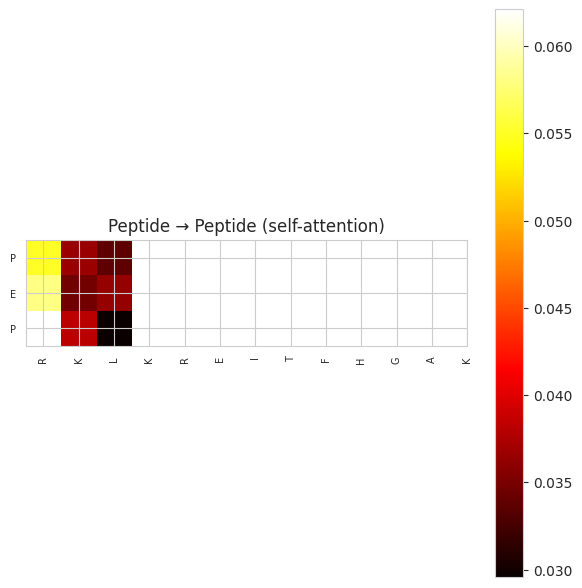

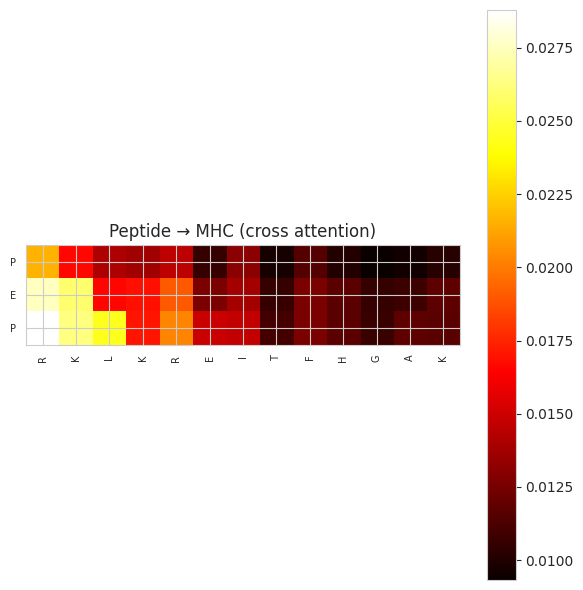

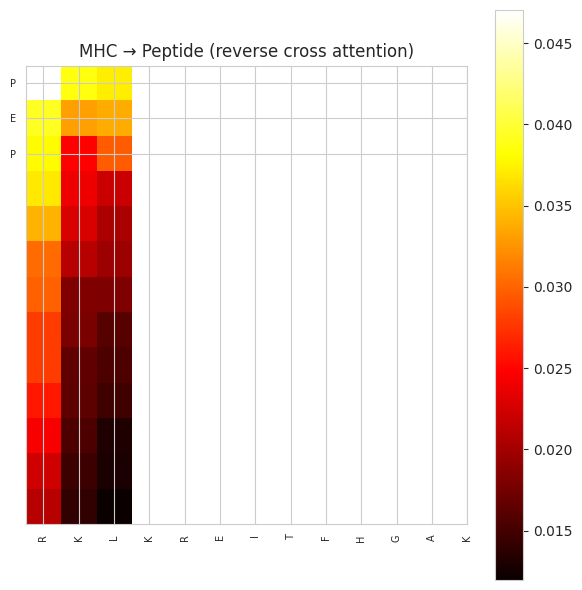

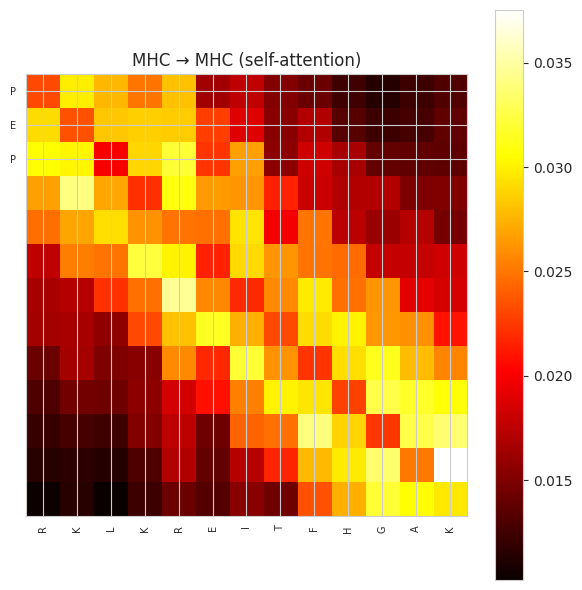


=== Visualization for Negative sample ===
Peptide: PEP
MHC Pseudo: NKLYGYASLTTIGTI
Peptide tokens: 2-4
MHC tokens    : 6-20


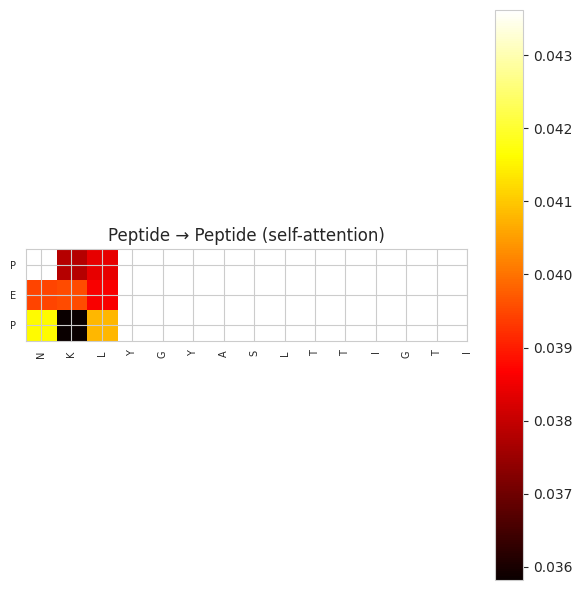

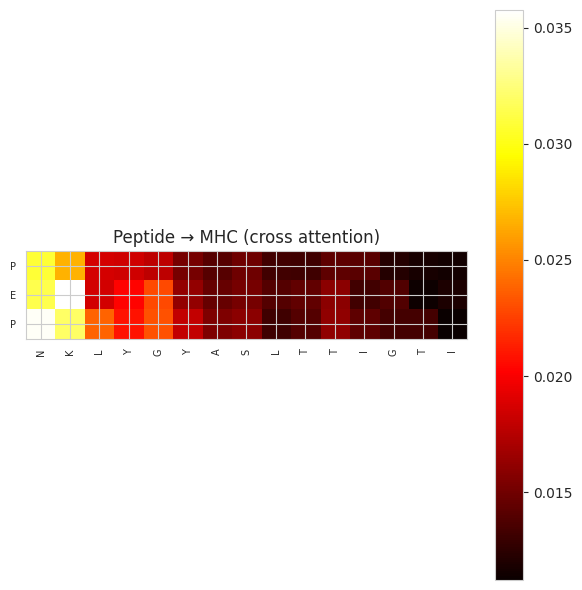

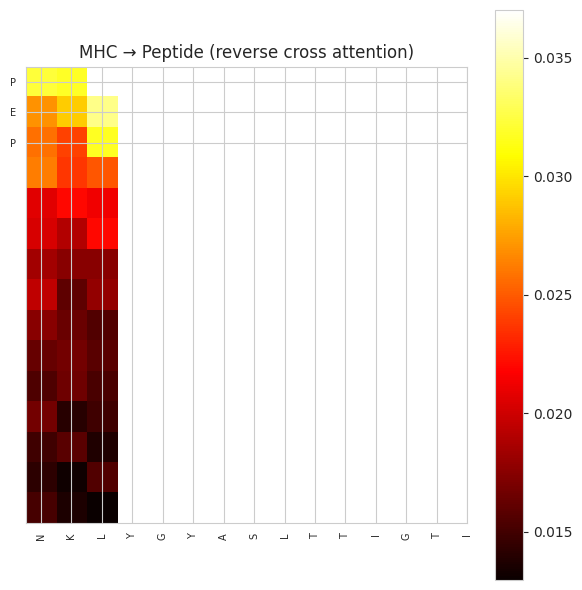

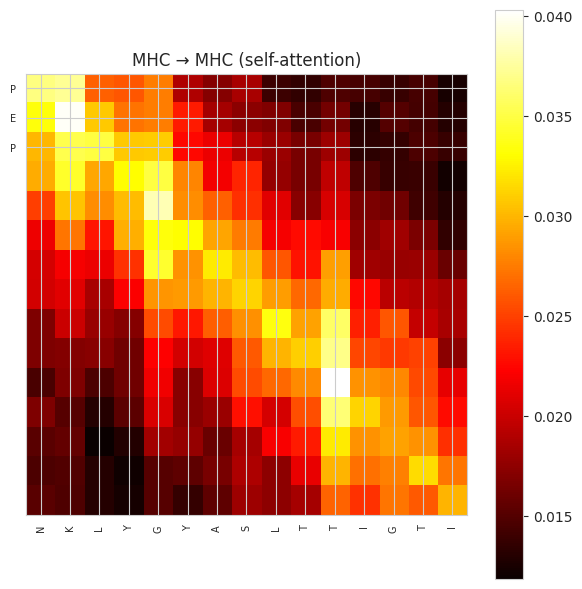

In [40]:
sample_pos = val_df[val_df.labels == 1].iloc[0]["text"]
sample_neg = val_df[val_df.labels == 0].iloc[0]["text"]

visualize_pep_mhc_attention(sample_pos, "Positive")
visualize_pep_mhc_attention(sample_neg, "Negative")


####  — Sequence Logos from Attention-Weighted Positions

In [58]:
import numpy as np

def attention_weighted_peptide(text):
    attn, enc = get_attention_map(text)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    pep_positions = [i for i,t in enumerate(tokens) if len(t)==1]  # single AA tokens
    weights = attn[:, pep_positions].mean(0)
    return tokens, weights

seqs = []

for text in val_df[val_df.labels==1]["Peptide"].sample(50):
    toks, w = attention_weighted_peptide(text)
    seq = "".join([t for t in toks if len(t)==1])
    seqs.append(seq)

with open("positive_peptide_logo.fasta","w") as f:
    for i,s in enumerate(seqs):
        f.write(f">seq{i}\n{s}\n")

print("Saved: positive_peptide_logo.fasta")


Saved: positive_peptide_logo.fasta


In [59]:
seqs ### for fine tunned based motifs discovery

['DSAFDVLSFTAEEKA',
 'PTLNGDDRHKIVNVD',
 'DSDYATEVSNMSRAQ',
 'YRMLEPTRVVNWEVI',
 'DYIIDHVDQHNATEI',
 'VFGIELMEVDPIGHL',
 'LRGGGGDMAEPSEAG',
 'GVIMMFLSLGVGADQ',
 'NREGKVVGLYGNGVV',
 'WTVYVGIVTMLSPML',
 'SKTFYVLPLRGKLSF',
 'RSSQWEVAFSVVSKT',
 'LRDPISAEISIQALS',
 'VSMMIAMEVVLRKRQ',
 'PVNTFVHESLADVQA',
 'IEGKVVQYENLKYTV',
 'ATETYFSLNNKFRNP',
 'TGASVVGPVPLPTEK',
 'AICKRIPNKKPGKKT',
 'YNYPAMLGHAGDMAG',
 'DDDYGEPIIITSYLQ',
 'ENPVVHFFRNIVTPR',
 'AFQEMENFLGPIAVG',
 'PLTSLTPRCNTAWNR',
 'VEIAEYRRLLRTVLE',
 'ASIDSMIDEIDFYEK',
 'DYMPVMKRYSAPSES',
 'FIVYIVFVYIPLFLI',
 'TLRLCVQSTHVDIRT',
 'VNLVDTLNSGQYTXX',
 'SNILDIDLRPASAWT',
 'GLITNTIAGVAGLIT',
 'DRTAGGYVAPNAHKK',
 'VKDKYMWCYSQVNKR',
 'PPGANGNPGPAGPPG',
 'EWNFRKDVNMVLQSS',
 'LKFYSKISEYRHYCY',
 'SIYVHTPSGSLVSSE',
 'CLDFYLMGRTRQRXX',
 'MKLVRFLMKLSHETV',
 'VSFGVWIRTPPAXXX',
 'PGTRMVMTTTANWLW',
 'DIDPYKEFGATVELL',
 'SVNMVSRLLLNRFTM',
 'KQDVFCDSKLMSAAI',
 'MMIWHSNLNDATYQR',
 'ERVRFLDRYFYNQEE',
 'DDFANDLKEGLRTFK',
 'SFTFTLKTPPAAKLL',
 'GVFLRKLTSRETALM']

In [27]:
print(os.listdir(model_path))


['README.md', 'adapter_model.safetensors', 'adapter_config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'training_args.bin']
